100%|██████████| 273/273 [00:00<00:00, 328.34it/s]


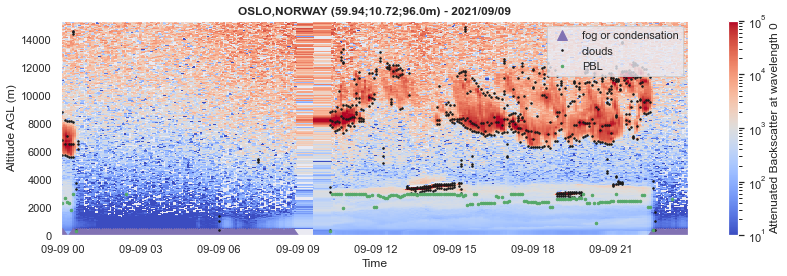

In [6]:
import aprofiles as apro
import numpy as np
import matplotlib.pyplot as plt

#path = "examples/data/L2_0-20000-006735_A20210908.nc"
path = "examples/data/L2_0-20000-001492_A20210909.nc"
apro_reader = apro.reader.ReadProfiles(path)
profiles = apro_reader.read()

#basic corrections
profiles.range_correction(inplace=True)
profiles.extrapolation_lowest_layers(zmin=300, inplace=True)
profiles.gaussian_filter(sigma=0.5, inplace=True)

#profiles analysis
profiles.detect_fog_or_condensation()
profiles.detect_clouds(time_avg=1, zmin=300, verbose=True)
profiles.detect_pbl(zmin=100, zmax=3000, under_clouds=True)

#plot image
profiles.plot(show_fog=True, show_clouds=True, show_pbl=True, log=True, vmin=1e1, vmax=1e5)

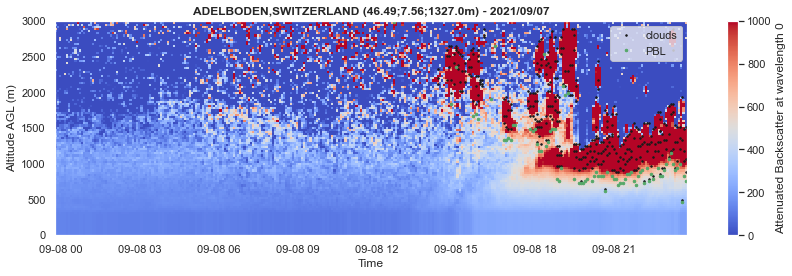

In [5]:
profiles.plot(vmin=0, vmax=1000, zmax=3000, show_clouds=True, show_pbl=True)

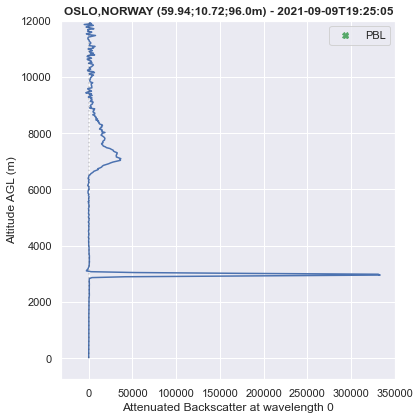

In [3]:
#plot single profile
profiles.plot(datetime=np.datetime64('2021-09-09T19:25:00'), zmax=12000, show_fog=True, show_clouds=True, show_pbl=True, log=False)

In [4]:
profiles._get_index_from_altitude_AGL(90)

3

In [5]:
np.nanmin([np.nan, 3000])

3000.0

In [7]:
profiles.data

<xarray.Dataset>
Dimensions:                          (altitude: 511, layer: 3, time: 273)
Coordinates:
  * time                             (time) datetime64[ns] 2021-09-09T00:00:04 ... 2021-09-09T23:55:06
  * altitude                         (altitude) float64 111.0 ... 1.541e+04
Dimensions without coordinates: layer
Data variables:
    start_time                       (time) datetime64[ns] ...
    latitude                         (time, altitude) float64 ...
    longitude                        (time, altitude) float64 ...
    attenuated_backscatter_0         (time, altitude) float64 95.42 ... -719.1
    uncertainties_att_backscatter_0  (time, altitude) float64 ...
    l0_wavelength                    float64 ...
    station_longitude                float64 10.72
    station_latitude                 float64 59.94
    station_altitude                 float64 96.0
    quality_flag                     (time, altitude) int64 ...
    vertical_visibility              (time) float64 ...
  